In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import sqlite3



In [19]:
# This creates a TS, where the distribution changes at different points deppending on a provided list of distribution shifts.
def Create_TimeSeries(s, dist_shifts):
    n = s//len(dist_shifts)
    m = s%len(dist_shifts)

    final = np.array([])
    
    for i in range(len(dist_shifts)-1):
        Y = abs(np.random.normal(dist_shifts[i][0], dist_shifts[i][1], n))
        final = np.concatenate((final, Y))
    
    final = np.concatenate((final, abs(np.random.normal(dist_shifts[-1][0], dist_shifts[-1][1], n+m)))) 
    
    return final + 0.1*np.roll(final, 1)

# Generating the data.

In [20]:
from numpy.random import randint
p = 0.5
pdist, steps = [1-p, p], [-1, 1]

datapoints = 50
seq_length = 500

train_Output = []

# These are the distribution shifts that will be applied to the time series
dist_shift = [(0, 1), (0, 5), (0, 20)]
#dist_shift = [(0,1), (2,0)]
#dist_shift = [((-1**x) * 100, 100) if x%5==0 else (0, 0) for x in range(30)]

for _ in range(datapoints):
    length = randint(seq_length//3, seq_length)
    X =  np.random.choice(steps, size=length, p=pdist)
    dist_shift = [(randint(-10, 10), randint(0, 20)) for __ in range(randint(1,5))]
    Y = Create_TimeSeries(length, dist_shift)
    T = np.cumsum(X*Y)
    
    input_data = T[:-1]
    labels_data = T[1:]

    train_Output.append((input_data, labels_data))


# DT_ACI vs ACI

In [21]:
inital_window_size = 50
alpha = 0.1
orignal_alpha = alpha 

# This function predicts a range of Y_t at the alpha level. By using alpha_t.
def C_t(alpha_t, scores, lookback_window ,sigma_t, t):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[t-lookback_window:t], 1 - alpha_t)
    positve_v = (sigma_t) + (abs(sigma_t) * Q)
    negative_v = (sigma_t) - (abs(sigma_t) * Q)
    return negative_v, positve_v

# This function returns 1 if the prediction lies in the interval, 0 otherwise.
def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1
    
def l(B, theta):
    return (orignal_alpha * (B - theta)) - min(0, (B - theta))
l_vec = np.vectorize(l)

def M_t(alpha, scores, t):
    for B in np.linspace(0, 1, 1000):
        Q = np.quantile(scores[t-50:t], 1 - B)
        if np.mean(scores[t-49:t+1] >= Q) <= alpha:
            return B


def plots(error_list, coverage, range_list, alpha_list, y): 
    _, axs = plt.subplots(2, 2, figsize=(30, 10))

    axs[0][0].plot(1 - pd.Series(error_list).rolling(50).mean())
    axs[0][0].axhline(coverage, color='r', linestyle='--')
    axs[0][0].set_title('Coverage')
    
    axs[0][1].plot([ele[0] for ele in range_list], label='Lower')
    axs[0][1].plot([ele[1] for ele in range_list], label='Upper')
    axs[0][1].plot(y[51:])
    axs[0][1].set_title('Prediction')
    axs[0][1].legend()

    axs[1][0].plot([ele[1]-ele[0] for ele in range_list], label='Distance')
    axs[1][0].axhline(np.mean([ele[1]-ele[0] for ele in range_list]), color='r', linestyle='--')
    axs[1][0].legend()
    axs[1][0].set_title('Distance between upper and lower bounds')

    axs[1][1].plot(alpha_list,label='our alpha')
    #axs[1][1].plot(B_t_list, label='alpha*')
    axs[1][1].legend()
    axs[1][1].set_title('Alpha')

    plt.show()

    return None

In [13]:
import numpy as np
a = np.array([0.5,3,1,4])


result = np.append(a[0], 0.1*a[:-1] + a[1:])
print(result)

[0.5  3.05 1.3  4.1 ]


In [23]:
def ACI(alpha, input_gamma, train_Output, plots=False):
    alpha = alpha
    orignal_alpha = alpha 
    gamma = input_gamma

    total_coverage_list = []

    for m, (xpred, y) in enumerate(train_Output):
        # Getting the prediction and the actual value.
        
        # Calculating the scores at each time step
        All_scores = (abs(y - xpred))/abs(xpred)

        error_list = []
        range_list = []
        alpha_list = []
        
        for i in range(51, len(All_scores)):
            # This is inclusive of i
            Coverage_t = C_t(alpha, All_scores, 50, xpred[i], i)
            range_list.append(Coverage_t)

            error_t = err_t(y[i], Coverage_t)
            error_list.append(error_t)

            alpha = min(max(alpha + (gamma * (orignal_alpha - error_t)), 0), 1)
            alpha_list.append(alpha)


        coverage = 1 - pd.Series(error_list).rolling(50).mean().mean()
        total_coverage_list.append(coverage)
        
        if m<10 and plots:
            plots(error_list, coverage, range_list, alpha_list, y)
            
        yield error_list, range_list, alpha_list
    
    #return np.mean(total_coverage_list), Coverage_list

In [24]:

def Adaptive_Window(alpha, input_gamma, train_Output, Isplots=False):
    alpha = alpha
    orignal_alpha = alpha 
    gamma = input_gamma
    origional_lookback = 50

    total_coverage_list = []

    for m, (xpred, y) in enumerate(train_Output):
        # Getting the prediction and the actual value.
        
        # Calculating the scores at each time step
        All_scores = (abs(y - xpred))/abs(xpred)

        error_list = []
        range_list = []
        alpha_list = []
        
        error_counter = 0
        for i in range(51, len(All_scores)):
            look_back = max(1, origional_lookback - 5*error_counter)
            Coverage_t = C_t(alpha, All_scores, look_back, xpred[i], i)
            range_list.append(Coverage_t)

            error_t = err_t(y[i], Coverage_t)
            error_list.append(error_t)
            
            alpha = min(max(alpha + (gamma * (orignal_alpha - error_t)), 0), 1)
            alpha_list.append(alpha)

            if error_t:
                error_counter+=1
            else:
                error_counter = max(0, error_counter-1)
                



        coverage = 1 - pd.Series(error_list).rolling(50).mean().mean()
        total_coverage_list.append(coverage)
        
        if m<10 and Isplots:
            plots(error_list, coverage, range_list, alpha_list, y)
            
        yield error_list, range_list, alpha_list
    
    #return np.mean(total_coverage_list), Coverage_list

In [25]:
from scipy.stats import norm
def Adaptive_Window(alpha, input_gamma, train_Output, Isplots=False):
    alpha = alpha
    orignal_alpha = alpha 
    gamma = input_gamma
    origional_lookback = 50
    look_back = origional_lookback

    total_coverage_list = []

    for m, (xpred, y) in enumerate(train_Output):
        # Getting the prediction and the actual value.
        
        # Calculating the scores at each time step
        All_scores = (abs(y - xpred))/abs(xpred)

        error_list = []
        range_list = []
        alpha_list = []
        error_distance_list = []
        
        error_counter = 0
        for i in range(51, len(All_scores)):
            Coverage_t = C_t(alpha, All_scores, look_back, xpred[i], i)
            range_list.append(Coverage_t)

            error_t = err_t(y[i], Coverage_t)
            error_list.append(error_t)

            # we will work out the error in the prediciton and then scale our lookback window accordingly.
            # greatest distance between prediciton and bound.
            max_distance = max(abs(Coverage_t[0] - y[i]), abs(Coverage_t[1] - y[i]))

            norm_mu, norm_std = norm.fit(All_scores[i-50:i])
            likelihood = norm.pdf(All_scores[i], norm_mu, norm_std)

            lookback = np.ceil(origional_lookback*likelihood)
            
            alpha = min(max(alpha + (gamma * (orignal_alpha - error_t)), 0), 1)
            alpha_list.append(alpha)


        coverage = 1 - pd.Series(error_list).rolling(50).mean().mean()
        total_coverage_list.append(coverage)
        
        if m<10 and Isplots:
            plots(error_list, coverage, range_list, alpha_list, y)
            
        yield error_list, range_list, alpha_list
    
    #return np.mean(total_coverage_list), Coverage_list

In [26]:
# AW = Adaptive_Window(0.4, 0.05, train_Output, True)
# for _ in range(10):
#     next(AW) 


In [27]:
def Dt_ACI(alpha, train_Output, plots=False):
    total_coverage_list = []
    # The hyperparameters for the DtACI model.
    orignal_alpha = alpha
    sigma = 0.01
    #nu = np.sqrt((3/seq_length) * (np.log()))


    for m, (xpred, y) in enumerate(train_Output):
        # Initialising the gamma candidates and the weights.
        candiate_gamma = np.array([0.001, 0.002, 0.032, 0.128, 0.05, 0.1, 0.15, 0.25, 0.3, 0.4, 0.5])
        candiate_alpha = np.array([[orignal_alpha for _ in candiate_gamma]])
        gamma_weights = np.array([1 for _ in candiate_gamma])
        chosen_index = []
        
        error_list = []
        range_list = []
        alpha_list = []
        alpha_error_list = []
        B_t_list = []
        
        # Calculating the scores at each time step
        All_scores = (abs(y - xpred))/abs(xpred)

        #nu = np.sqrt((3/50) * (np.log(50*i) + 2/((1-alpha)**2 * alpha**2)))
        for i in range(51, len(All_scores)):
            nu = np.sqrt(3/50 * (np.log(10*50) + 2)/((1-alpha)**2 * alpha**2))
            
            # The probability of each gamma from the weights from step t.
            Wt = gamma_weights.sum()
            gamma_probabilites = gamma_weights/Wt
            
            # Choosing a alpha from the probabilites from the gamma candidates. Then calculating the coverage.
            chosen_alpha_t = np.random.choice(candiate_alpha[-1], p=gamma_probabilites)
            candiate_alpha_index = np.where(candiate_alpha[-1] == chosen_alpha_t)[0][0]
            chosen_index.append(candiate_alpha_index)

            #chosen_alpha_t = sum(gamma_probabilites * candiate_alpha[-1])
            alpha_list.append(chosen_alpha_t)
            
            Coverage_t = C_t(chosen_alpha_t, All_scores, xpred[i], i)
            
            
            range_list.append(Coverage_t)
            err_true = err_t(y[i], Coverage_t)
            error_list.append(err_true)

            # TIME FRONTIER -------

            # B is the sig level, we want the smallest one so that y is just in it.
            for possi in abs(np.linspace(-1, 0, 1000)):
                Cpossi= C_t(possi, All_scores, xpred[i], i)
                if Cpossi[0] < y[i] < Cpossi[1]:
                    B_t = possi
                    break
            
            B_t_list.append(B_t)
            
            
            # Updating the weights.
            new_weights = gamma_weights * np.exp(-nu * l_vec(B_t, candiate_alpha[-1]))
            sumW, lenW = sum(new_weights), len(new_weights)
            final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
            gamma_weights = final_weights

            # Calculating the coverage and error at each time step, for different alpha values.
            alphai_errors = np.array([err_t(y[i], C_t(alpha_i, All_scores, xpred[i], i)) for alpha_i in candiate_alpha[-1]])
            alpha_error_list.append(alphai_errors)


            # Updating the alpha values.
            new_alphas = candiate_alpha[-1] + (candiate_gamma * (orignal_alpha - alphai_errors))
            candiate_alpha = np.vstack((candiate_alpha, new_alphas))

        coverage = 1 - pd.Series(error_list).rolling(50).mean().mean()
        total_coverage_list.append(coverage)
        
        if m<5 and plots:
            plots(error_list, coverage, range_list, alpha_list, B_t_list)

        yield error_list, range_list, alpha_list, chosen_index
        
    #return np.mean(total_coverage_list), range_list

In [28]:
print(6/2*3)

9.0


ACI Coverage: 0.7048087431693989, DtACI Coverage: 0.7048087431693989
ACI variance: 0.0021845262623548037, DtACI variance: 0.0021845262623548037


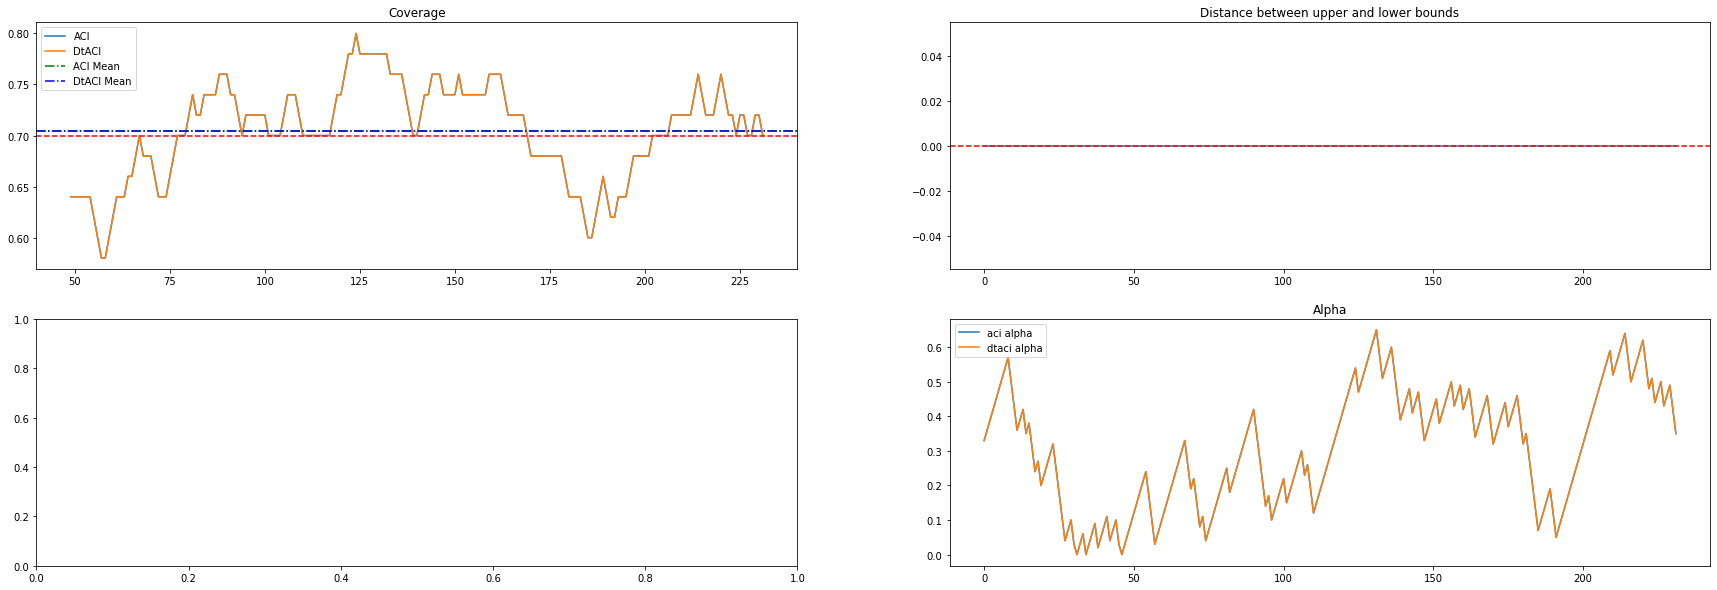

ACI Coverage: 0.701074448311042, DtACI Coverage: 0.701074448311042
ACI variance: 0.003027196316088985, DtACI variance: 0.003027196316088985


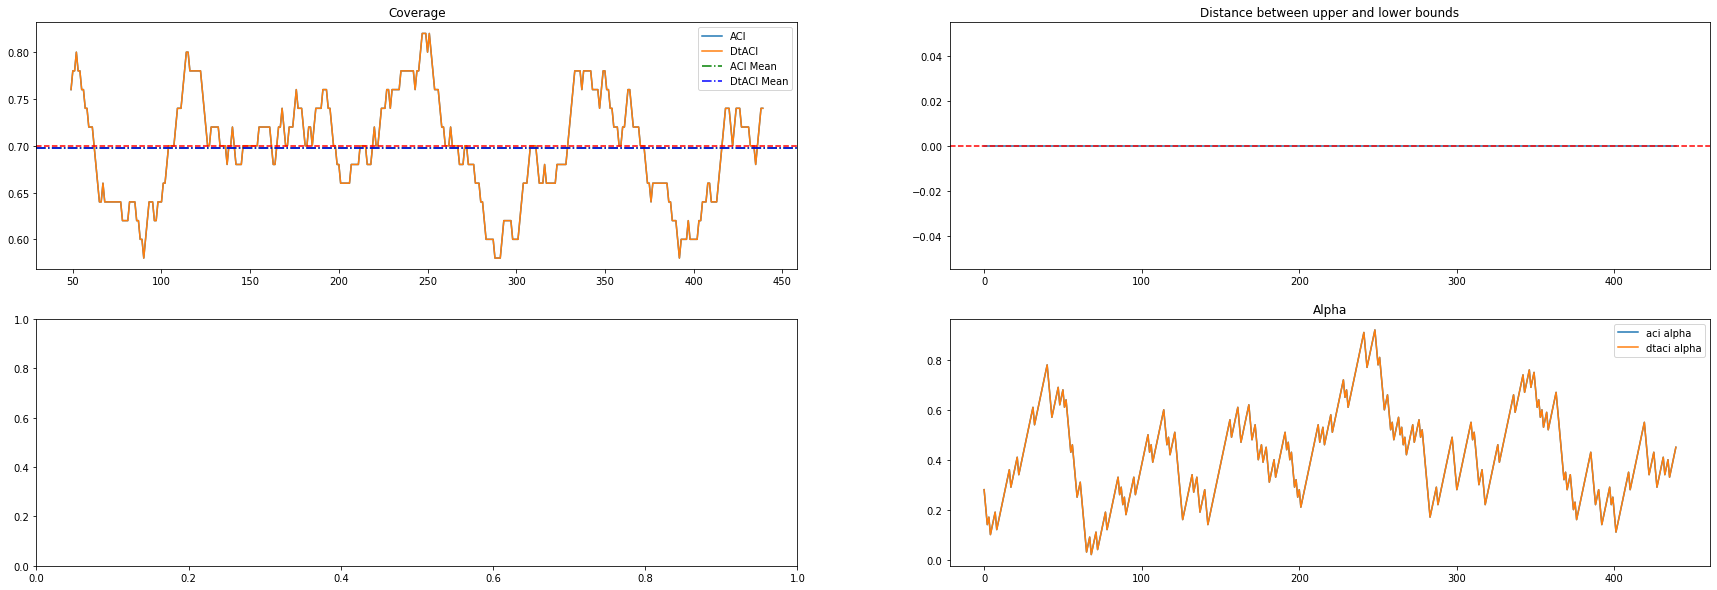

ACI Coverage: 0.6994983501560793, DtACI Coverage: 0.6994983501560793
ACI variance: 0.0010571622287968447, DtACI variance: 0.0010571622287968447


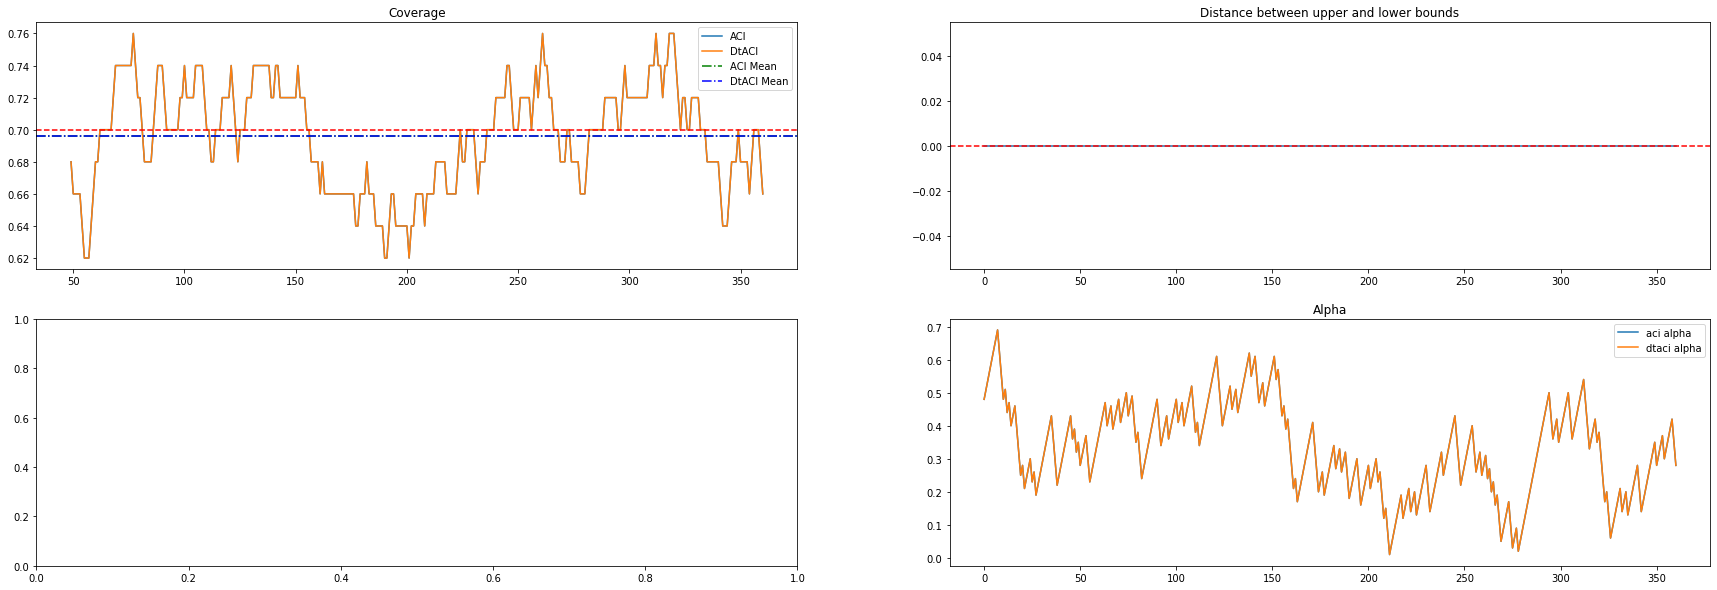

ACI Coverage: 0.6837146717079685, DtACI Coverage: 0.6837146717079685
ACI variance: 0.002521841794569065, DtACI variance: 0.002521841794569065


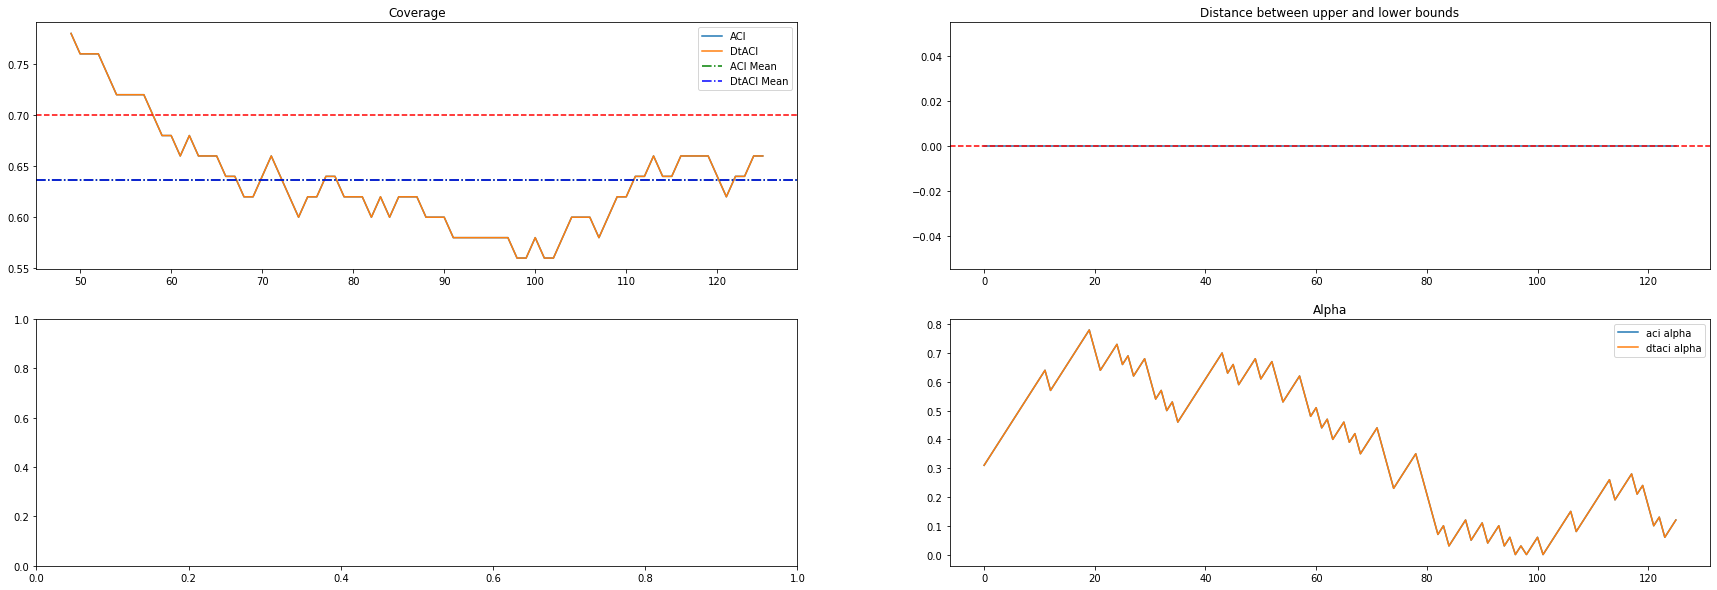

ACI Coverage: 0.6846212219024573, DtACI Coverage: 0.6846212219024573
ACI variance: 0.003995210259680448, DtACI variance: 0.003995210259680448


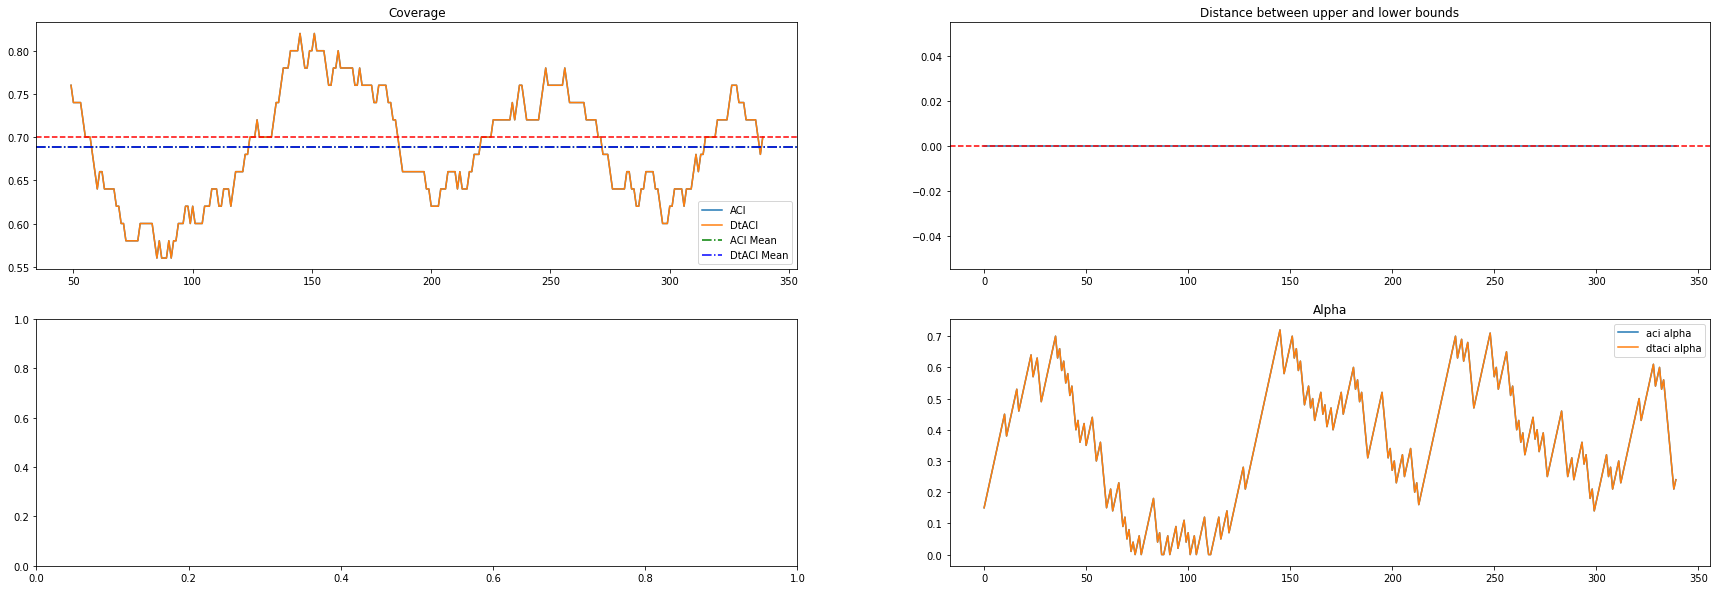

ACI Coverage: 0.6853954626964921, DtACI Coverage: 0.6853954626964921
ACI variance: 0.00455812888888889, DtACI variance: 0.00455812888888889


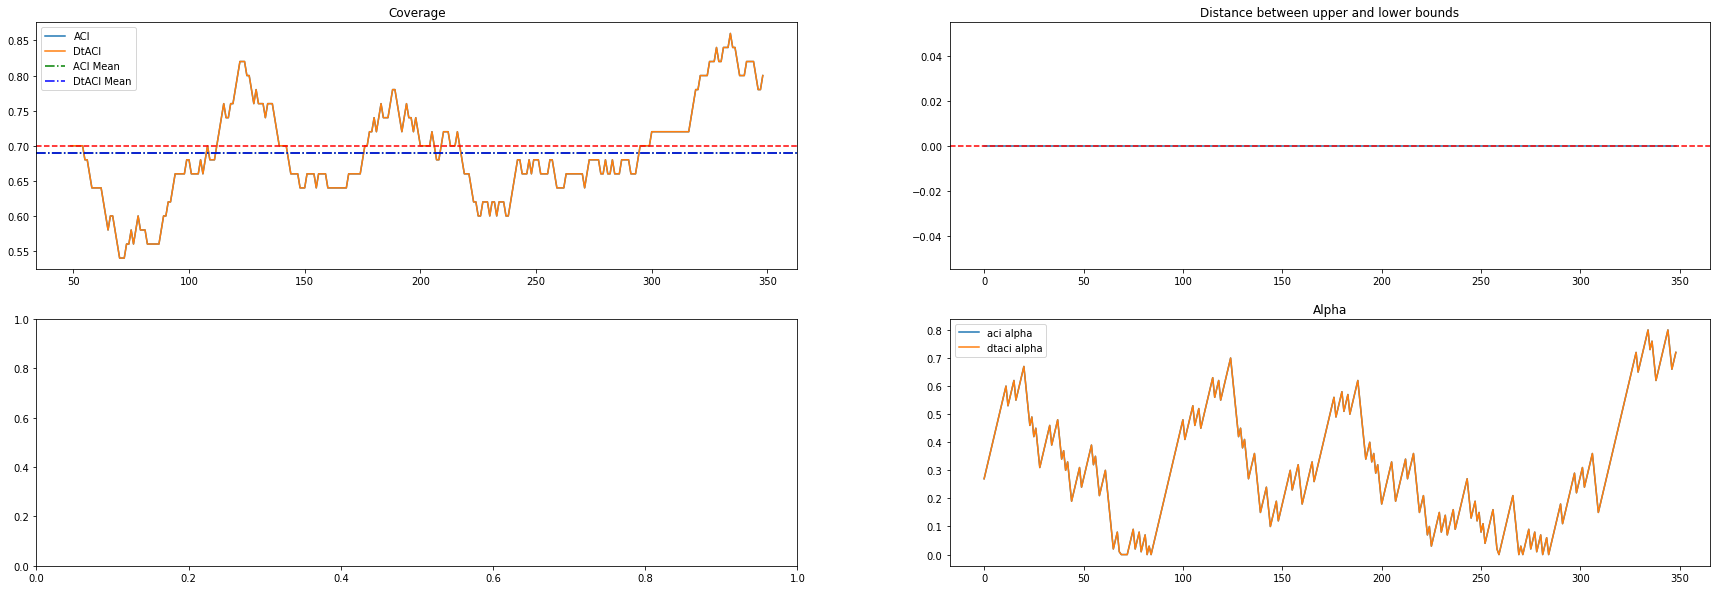

ACI Coverage: 0.6877970961043823, DtACI Coverage: 0.6877970961043823
ACI variance: 0.0026434054696789543, DtACI variance: 0.0026434054696789543


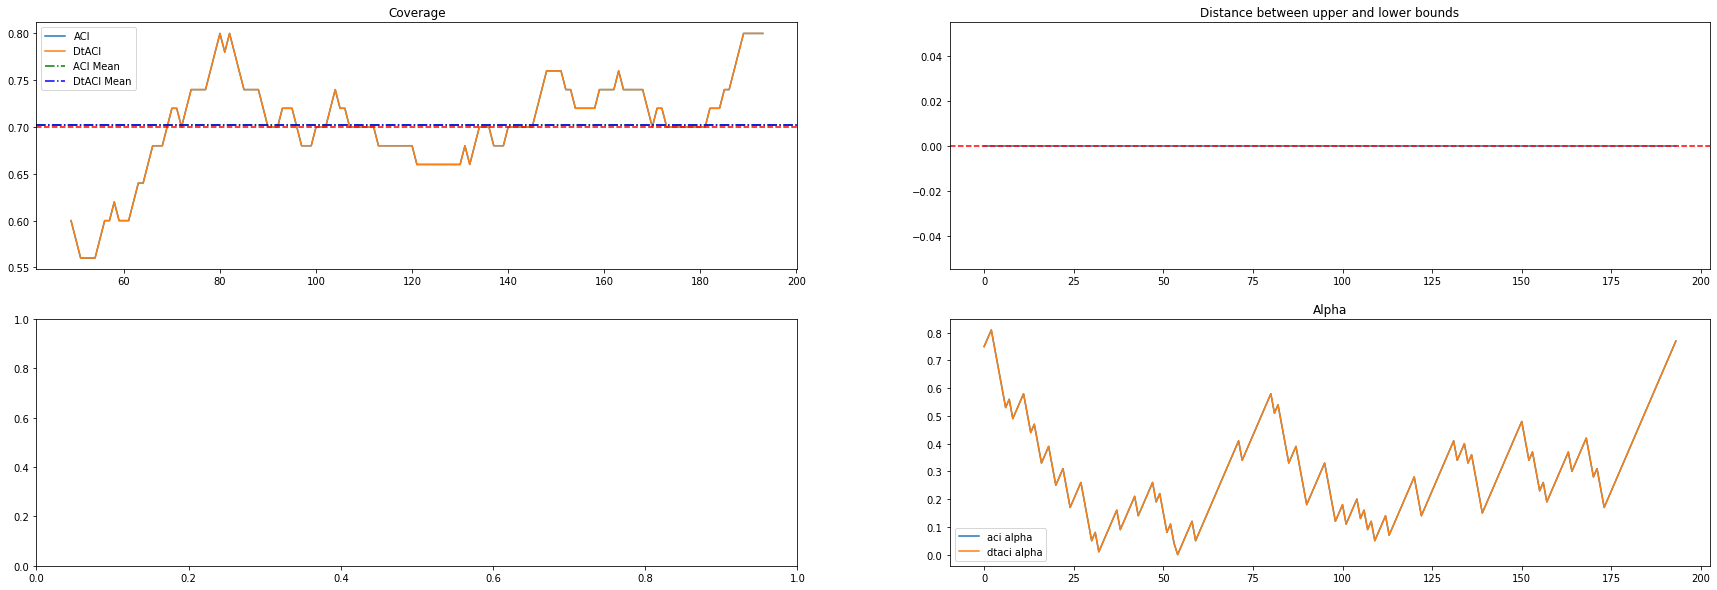

ACI Coverage: 0.68690517967957, DtACI Coverage: 0.68690517967957
ACI variance: 0.00467162089100346, DtACI variance: 0.00467162089100346


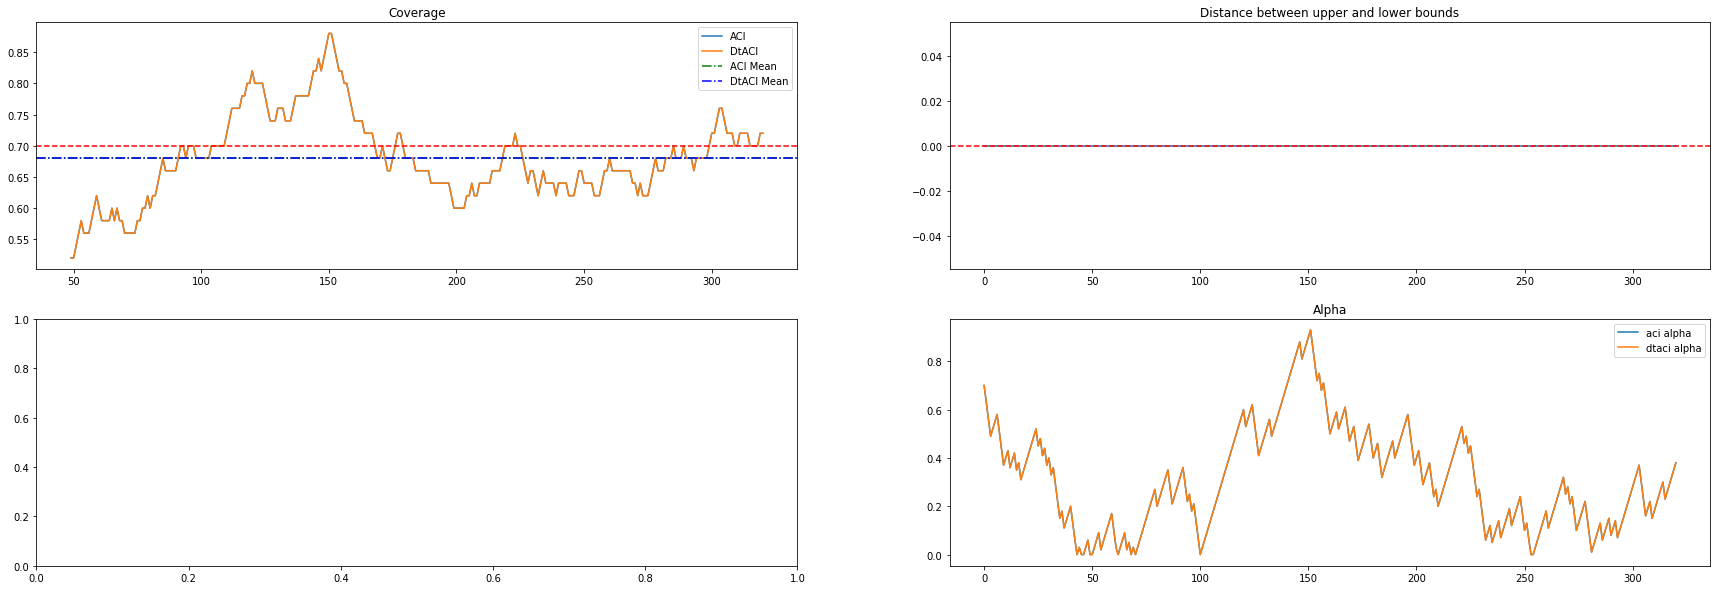

ACI Coverage: 0.6879108579543961, DtACI Coverage: 0.6879108579543961
ACI variance: 0.0034415718594165267, DtACI variance: 0.0034415718594165267


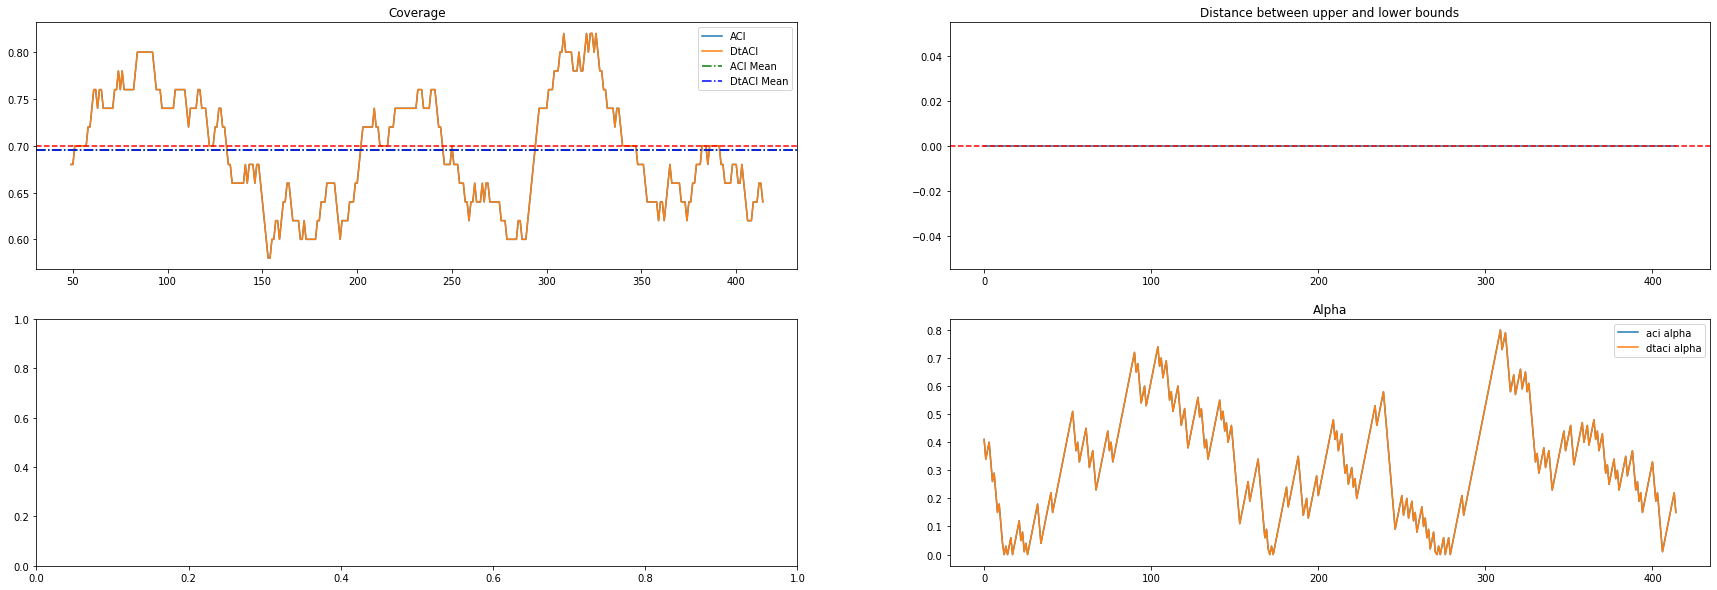

ACI Coverage: 0.6896292778623785, DtACI Coverage: 0.6896292778623785
ACI variance: 0.004535257123856064, DtACI variance: 0.004535257123856064


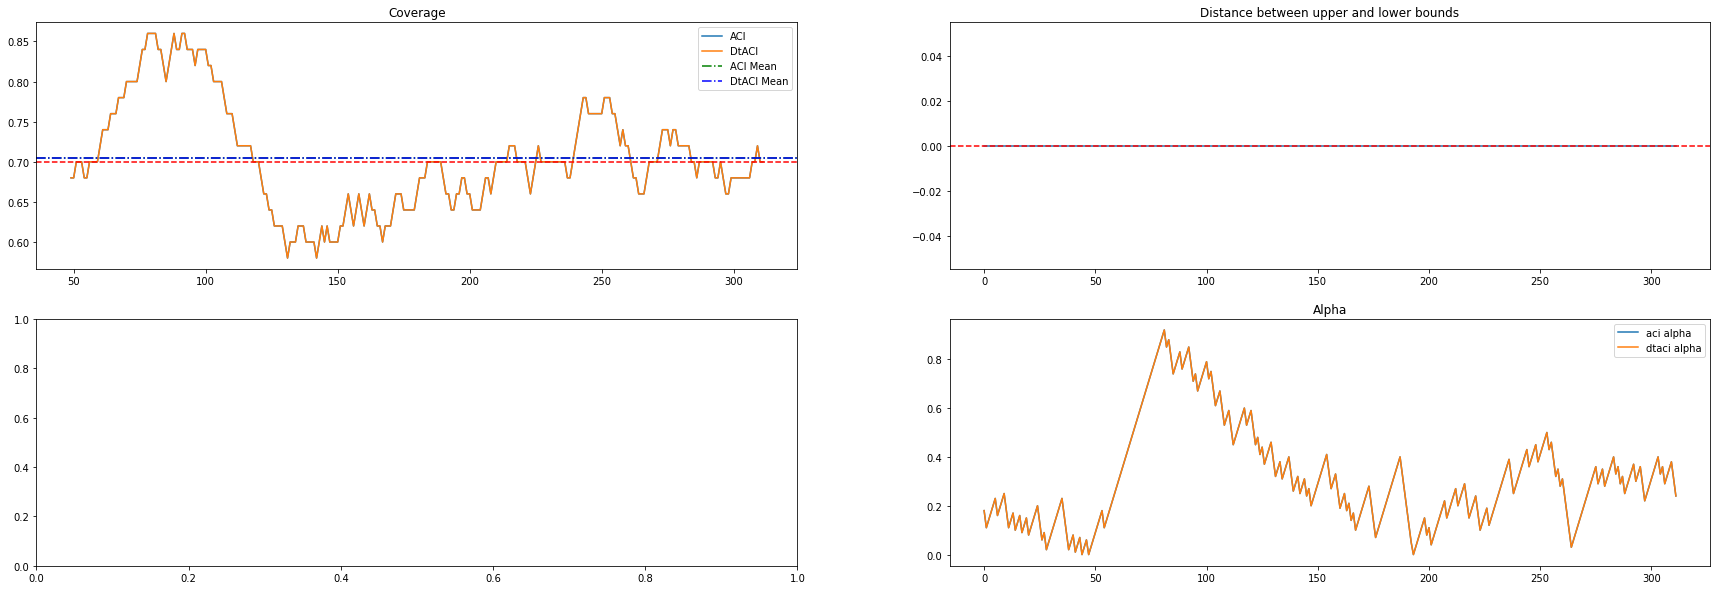

ACI Coverage: 0.6899626801745898, DtACI Coverage: 0.6899626801745898
ACI variance: 0.0026363844946262543, DtACI variance: 0.0026363844946262543
ACI Coverage: 0.6889615166557671, DtACI Coverage: 0.6889615166557671
ACI variance: 0.011691518737672584, DtACI variance: 0.011691518737672584
ACI Coverage: 0.689110464052811, DtACI Coverage: 0.689110464052811
ACI variance: 0.004304766651650069, DtACI variance: 0.004304766651650069
ACI Coverage: 0.6876379040244611, DtACI Coverage: 0.6876379040244611
ACI variance: 0.0017321424442132034, DtACI variance: 0.0017321424442132034
ACI Coverage: 0.6876350395367544, DtACI Coverage: 0.6876350395367544
ACI variance: 0.006538772632590932, DtACI variance: 0.006538772632590932
ACI Coverage: 0.6875220581988011, DtACI Coverage: 0.6875220581988011
ACI variance: 0.00340632990010869, DtACI variance: 0.00340632990010869
ACI Coverage: 0.6877040805609989, DtACI Coverage: 0.6877040805609989
ACI variance: 0.001768113154437981, DtACI variance: 0.001768113154437981
ACI Co

In [29]:
alpha = 0.3

ACI_gen = ACI(alpha, 0.1, train_Output, False)
Dt_ACI_gen = Dt_ACI(alpha, train_Output, False)
AW_gen = Adaptive_Window(alpha, 0.1, train_Output, False)

aci_average_coverage_multi = []
dtaci_average_coverage_multi = []

for x, stock in enumerate(train_Output):
    aci_error_list, aci_range, aci_alpha = next(ACI_gen)
    #print('Got ACI')
    dtaci_error_list, dtaci_range, dtaci_alpha, = next(AW_gen)
    #print('Got DtACI')

    aci_distance = np.array([ele[1]-ele[0] for ele in aci_range])
    dtaci_distance = np.array([ele[1]-ele[0] for ele in dtaci_range])

    aci_coverage_t = 1 - pd.Series(aci_error_list).rolling(50).mean()
    dtaci_coverage_t = 1 - pd.Series(dtaci_error_list).rolling(50).mean()

    aci_average_coverage = aci_coverage_t.mean()
    dtaci_average_coverage = dtaci_coverage_t.mean()

    aci_average_coverage_multi.append(aci_average_coverage)
    dtaci_average_coverage_multi.append(dtaci_average_coverage)


    if x<10:
        print(f'ACI Coverage: {np.mean(aci_average_coverage_multi)}, DtACI Coverage: {np.mean(dtaci_average_coverage_multi)}')
        print(f'ACI variance: {np.var(aci_coverage_t)}, DtACI variance: {np.var(dtaci_coverage_t)}')

        fig, axs = plt.subplots(2, 2, figsize=(30, 10))
        axs[0][0].plot(aci_coverage_t, label='ACI')
        axs[0][0].plot(dtaci_coverage_t, label='DtACI')
        axs[0][0].axhline(aci_average_coverage, color='g', linestyle='-.', label='ACI Mean')
        axs[0][0].axhline(dtaci_average_coverage, color='b', linestyle='-.', label='DtACI Mean')

        axs[0][0].axhline(1 - alpha, color='r', linestyle='--')
        axs[0][0].legend()
        axs[0][0].set_title('Coverage')

        axs[0][1].plot(aci_distance - dtaci_distance , label='Difference in predictions.')
        axs[0][1].axhline(np.mean(aci_distance - dtaci_distance), color='r', linestyle='--')
        axs[0][1].set_title('Distance between upper and lower bounds')

        #axs[1][0].plot(chosen, label='dtaci chosen')
        #axs[1][0].set_title('Prediction')
        #axs[1][0].legend()

        axs[1][1].plot(aci_alpha,label='aci alpha')
        axs[1][1].plot(dtaci_alpha, label='dtaci alpha')
        #axs[1][1].plot(alpha_star, label='alpha*')
        axs[1][1].legend()
        axs[1][1].set_title('Alpha')
        
        plt.show()
    
    else:
        if x%20:
            print(f'ACI Coverage: {np.mean(aci_average_coverage_multi)}, DtACI Coverage: {np.mean(dtaci_average_coverage_multi)}')
            print(f'ACI variance: {np.var(aci_coverage_t)}, DtACI variance: {np.var(dtaci_coverage_t)}')

    



In [ ]:
# The main critique of ACI is that it just corrects for its mistakes. So it will be intresting to see if you just take some random samples of the coverage how close they woudld be to the desired level.
# Would it be easier to just give different sequence lengths as inputs and see the effect of this.

Observed that sometimes. prob due to beng unluck we have that one weight gets over assigned probabilty and then it gets chosen almost every time which can cause a terrible result which throws of the entire average. Am also noticing that the variamce is of dtaci is consittently lower which supports the hypothesis that it is not correctig its mistakes.

Also the fact that there is chanve involved means that sometimes a clearly bad weight is chosen by chance.